<a href="https://colab.research.google.com/github/prabal5ghosh/UCA-M2-SEMESTER1/blob/main/deep%20learning/Copy_of_TP7_Advanced_DL_DSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>TP7: Improving a model!</h1></center>

# Warning :
# "File -> Save a copy in Drive" before starting to modify the notebook, otherwise changes won't be saved.

In [1]:
! wget https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py

--2024-11-15 13:14:41--  https://remysun.github.io/uploads/DSAI_ADL_TP9/utils.py
Resolving remysun.github.io (remysun.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to remysun.github.io (remysun.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [application/octet-stream]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2024-11-15 13:14:41 (43.9 MB/s) - ‘utils.py’ saved [2627/2627]



In [2]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [4]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define a cnn based feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define a classifier on the final features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # /!\ Softmax is built into the loss functions
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output



def get_dataset(batch_size, cuda=False):
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):

    # Set layers to train or eval mode
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # Iterate on dataset batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # get metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # Update averages
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)

        # Print out values
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # Iterate over epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # Plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 2.264s (2.264s)	Loss 2.3047 (2.3047)	Prec@1   7.0 (  7.0)	Prec@5  46.9 ( 46.9)


<Figure size 640x480 with 0 Axes>

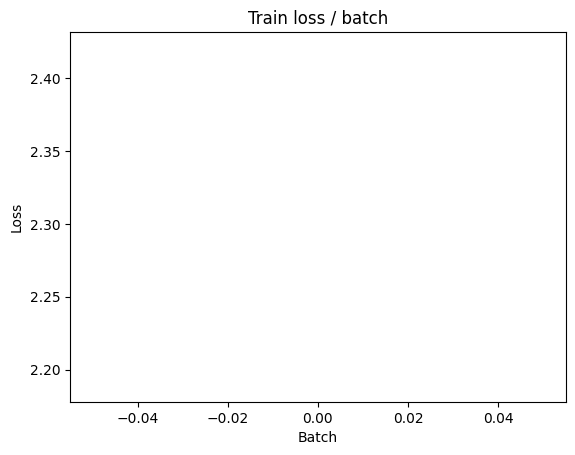

[TRAIN Batch 200/391]	Time 0.027s (0.032s)	Loss 2.0121 (2.2372)	Prec@1  26.6 ( 16.0)	Prec@5  79.7 ( 62.2)


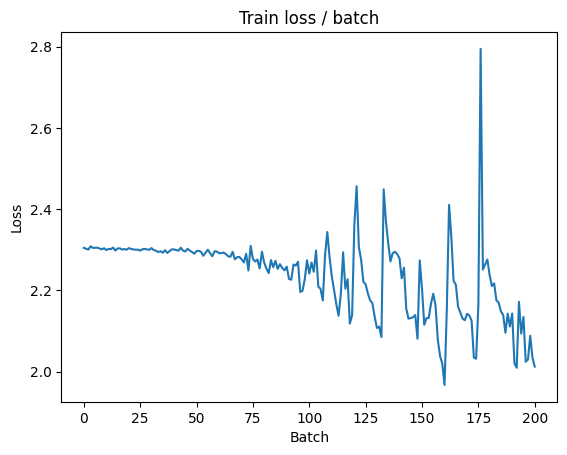


===============> Total time 11s	Avg loss 2.1197	Avg Prec@1 21.58 %	Avg Prec@5 70.08 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 1.7850 (1.7850)	Prec@1  42.2 ( 42.2)	Prec@5  84.4 ( 84.4)

===============> Total time 1s	Avg loss 1.8084	Avg Prec@1 35.94 %	Avg Prec@5 83.66 %



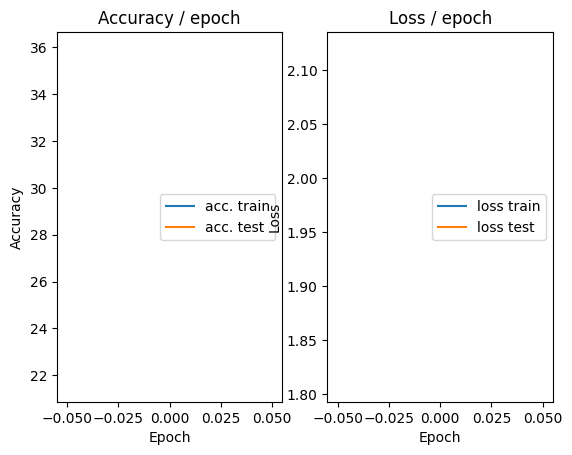

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.131s (0.131s)	Loss 1.8973 (1.8973)	Prec@1  30.5 ( 30.5)	Prec@5  80.5 ( 80.5)


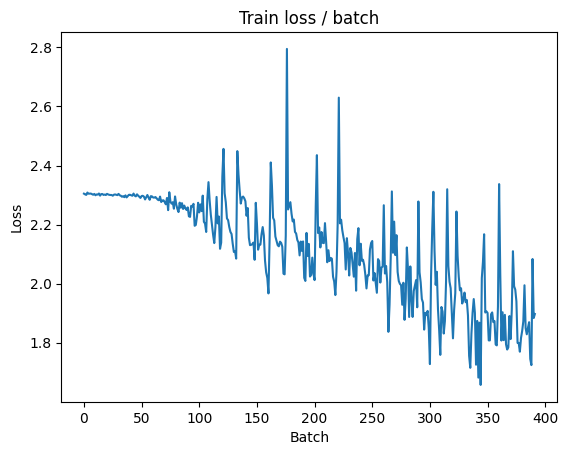

[TRAIN Batch 200/391]	Time 0.008s (0.022s)	Loss 1.7421 (1.7443)	Prec@1  39.8 ( 37.0)	Prec@5  87.5 ( 86.9)


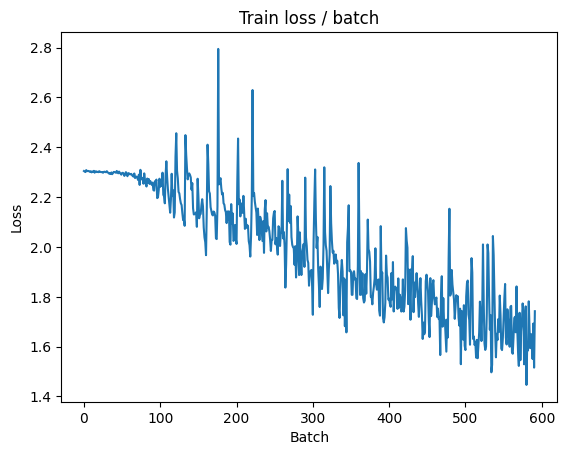


===============> Total time 8s	Avg loss 1.6594	Avg Prec@1 40.25 %	Avg Prec@5 88.61 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 1.3760 (1.3760)	Prec@1  54.7 ( 54.7)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4585	Avg Prec@1 47.41 %	Avg Prec@5 92.45 %



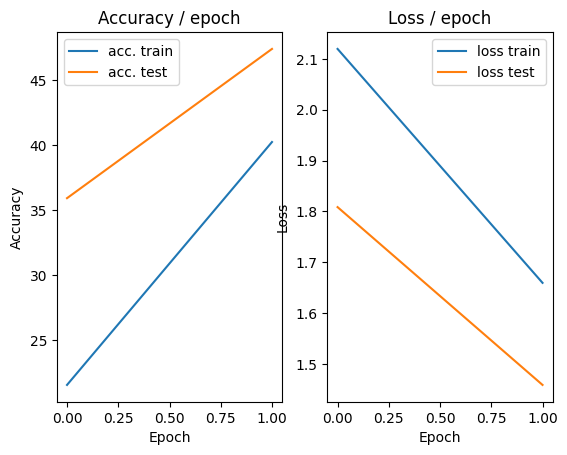

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.128s (0.128s)	Loss 1.4555 (1.4555)	Prec@1  47.7 ( 47.7)	Prec@5  93.8 ( 93.8)


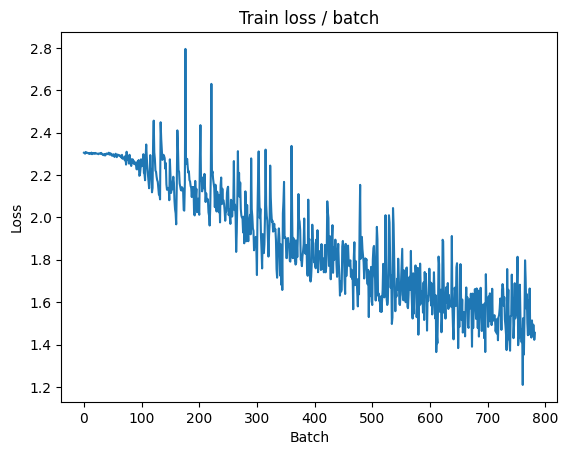

[TRAIN Batch 200/391]	Time 0.009s (0.022s)	Loss 1.3514 (1.4413)	Prec@1  54.7 ( 48.3)	Prec@5  94.5 ( 92.2)


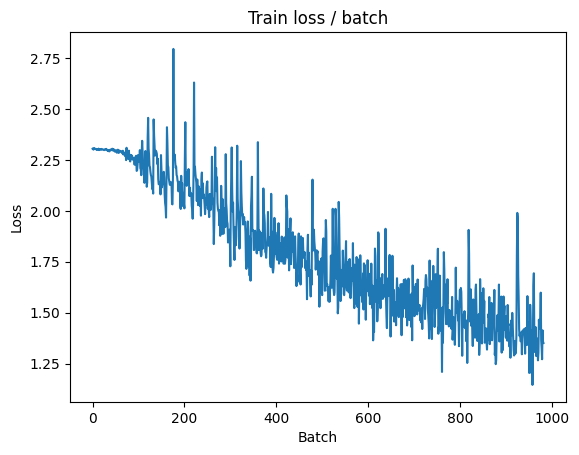


===============> Total time 8s	Avg loss 1.4008	Avg Prec@1 49.90 %	Avg Prec@5 92.81 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.1492 (1.1492)	Prec@1  64.8 ( 64.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.2863	Avg Prec@1 53.62 %	Avg Prec@5 93.90 %



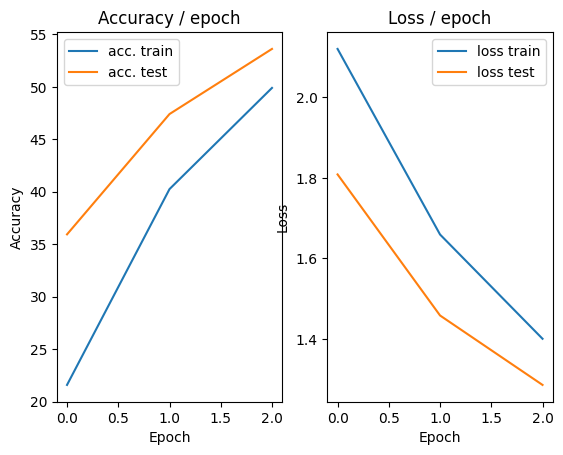

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 1.1892 (1.1892)	Prec@1  53.1 ( 53.1)	Prec@5  97.7 ( 97.7)


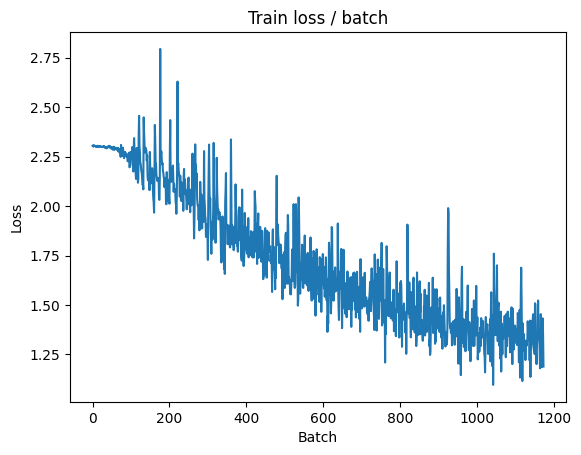

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 1.4592 (1.2663)	Prec@1  54.7 ( 55.0)	Prec@5  90.6 ( 94.6)


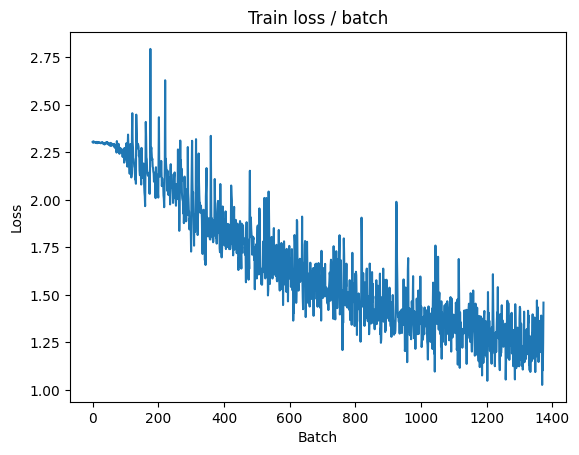


===============> Total time 9s	Avg loss 1.2341	Avg Prec@1 56.20 %	Avg Prec@5 94.87 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.2396 (1.2396)	Prec@1  56.2 ( 56.2)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.2769	Avg Prec@1 54.22 %	Avg Prec@5 94.61 %



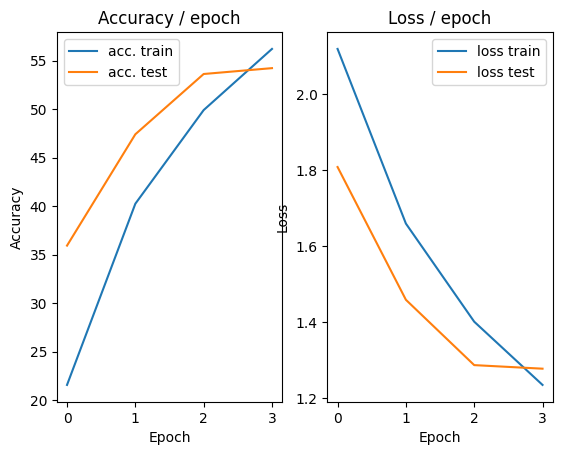

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 1.1264 (1.1264)	Prec@1  64.1 ( 64.1)	Prec@5  96.1 ( 96.1)


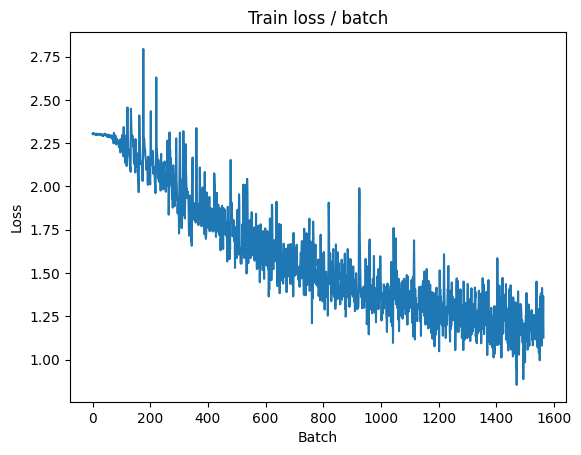

[TRAIN Batch 200/391]	Time 0.023s (0.030s)	Loss 1.3061 (1.1183)	Prec@1  53.1 ( 60.4)	Prec@5  90.6 ( 95.9)


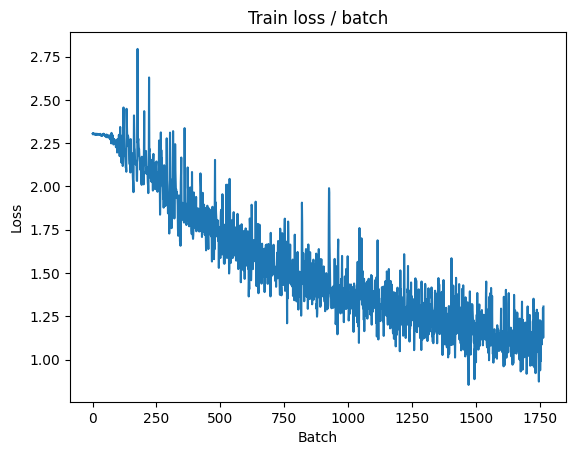


===============> Total time 10s	Avg loss 1.0917	Avg Prec@1 61.54 %	Avg Prec@5 96.08 %

[EVAL Batch 000/079]	Time 0.113s (0.113s)	Loss 1.1195 (1.1195)	Prec@1  54.7 ( 54.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.2951	Avg Prec@1 54.03 %	Avg Prec@5 94.56 %



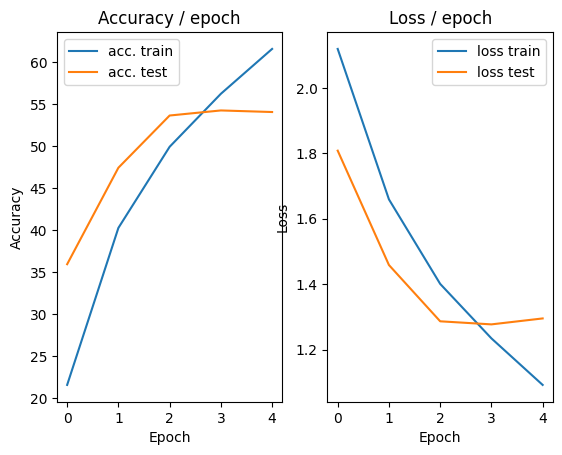

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 1.1687 (1.1687)	Prec@1  56.2 ( 56.2)	Prec@5  93.8 ( 93.8)


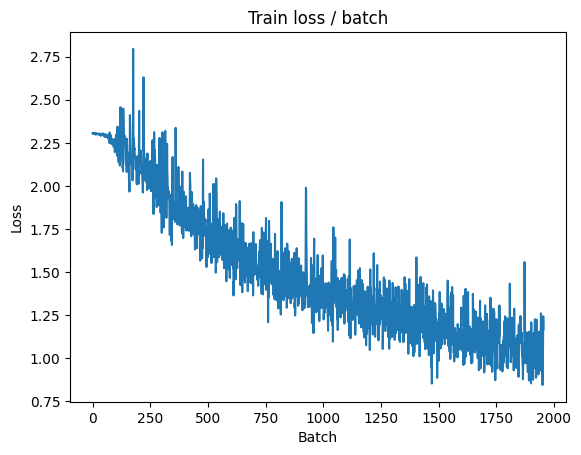

[TRAIN Batch 200/391]	Time 0.032s (0.027s)	Loss 0.9230 (0.9864)	Prec@1  67.2 ( 65.6)	Prec@5  96.9 ( 96.9)


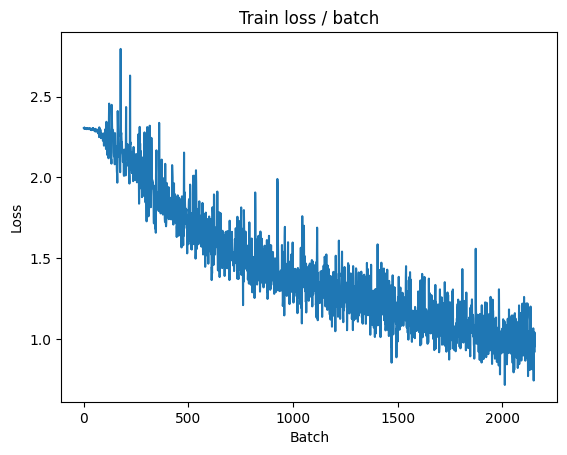


===============> Total time 9s	Avg loss 0.9729	Avg Prec@1 65.82 %	Avg Prec@5 96.98 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 1.0410 (1.0410)	Prec@1  64.1 ( 64.1)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.1366	Avg Prec@1 61.01 %	Avg Prec@5 95.82 %



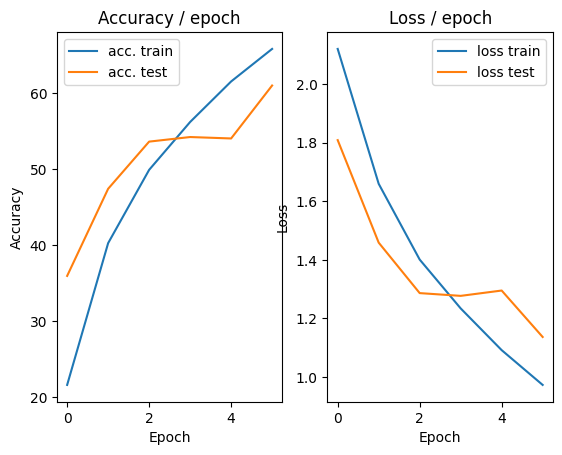

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 1.0013 (1.0013)	Prec@1  62.5 ( 62.5)	Prec@5  98.4 ( 98.4)


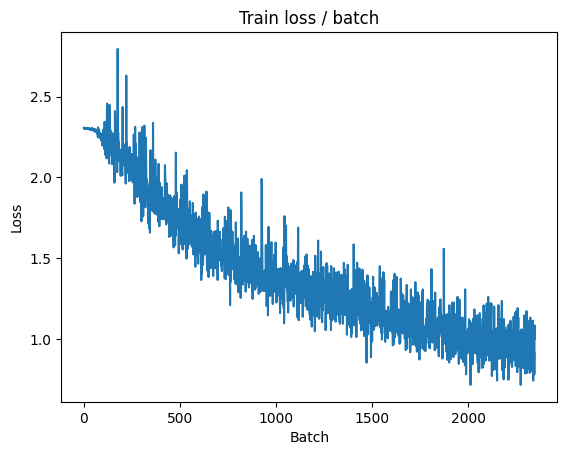

[TRAIN Batch 200/391]	Time 0.038s (0.027s)	Loss 0.9424 (0.8606)	Prec@1  64.8 ( 69.8)	Prec@5  99.2 ( 97.7)


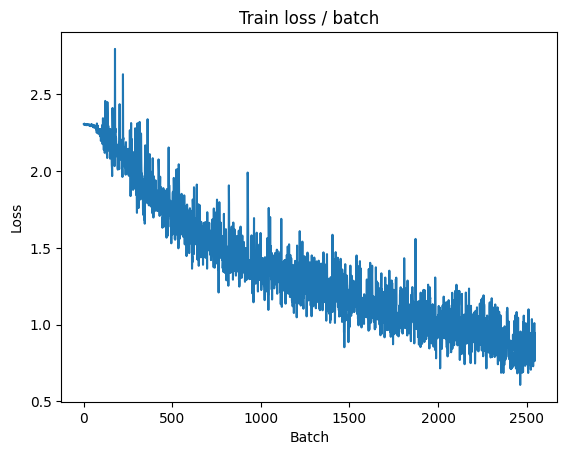


===============> Total time 9s	Avg loss 0.8632	Avg Prec@1 69.68 %	Avg Prec@5 97.65 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 0.9047 (0.9047)	Prec@1  66.4 ( 66.4)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.0056	Avg Prec@1 64.65 %	Avg Prec@5 96.84 %



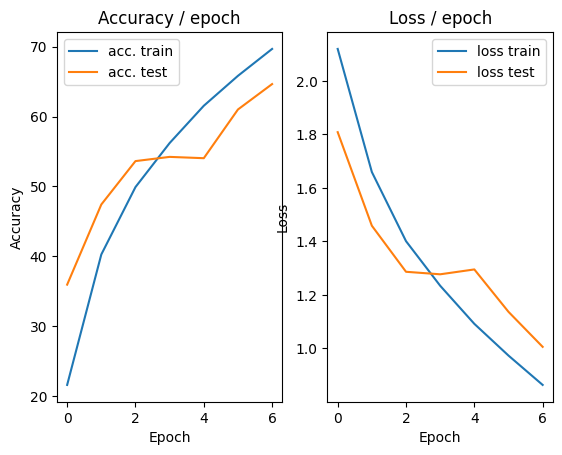

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.7810 (0.7810)	Prec@1  75.0 ( 75.0)	Prec@5  99.2 ( 99.2)


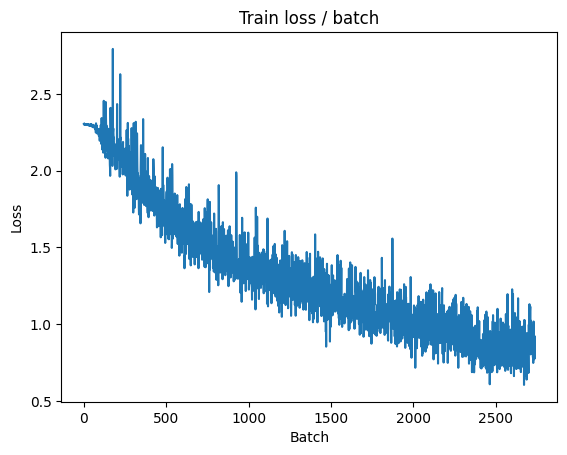

[TRAIN Batch 200/391]	Time 0.049s (0.024s)	Loss 0.5533 (0.7506)	Prec@1  80.5 ( 74.1)	Prec@5  99.2 ( 98.1)


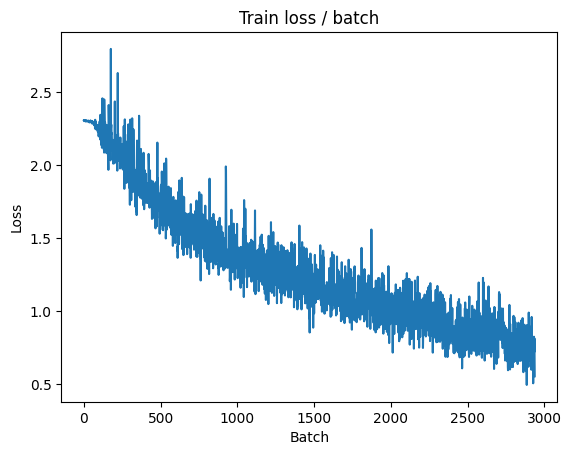


===============> Total time 9s	Avg loss 0.7608	Avg Prec@1 73.53 %	Avg Prec@5 98.17 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.9281 (0.9281)	Prec@1  65.6 ( 65.6)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 0.9176	Avg Prec@1 68.30 %	Avg Prec@5 97.20 %



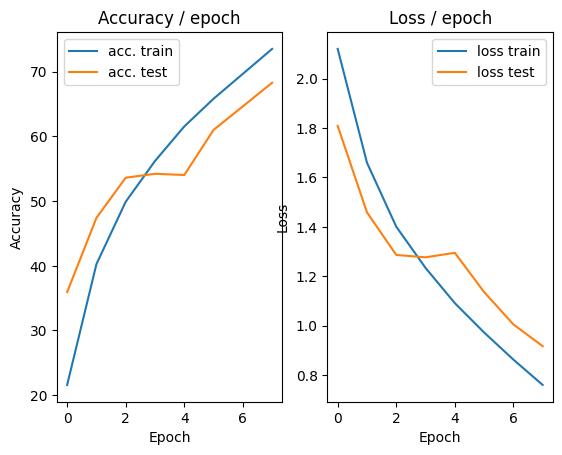

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 0.6480 (0.6480)	Prec@1  75.8 ( 75.8)	Prec@5  99.2 ( 99.2)


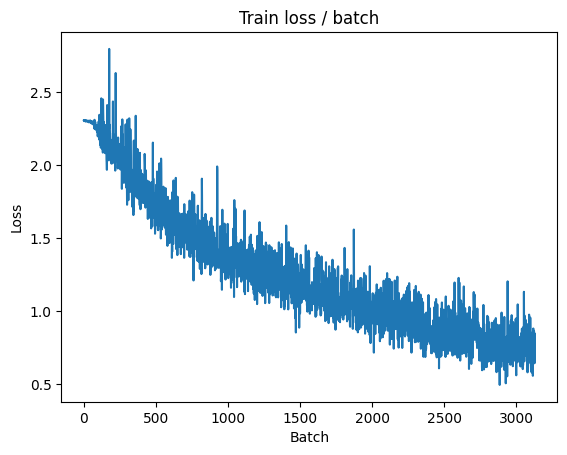

[TRAIN Batch 200/391]	Time 0.018s (0.023s)	Loss 0.6779 (0.6568)	Prec@1  75.8 ( 77.1)	Prec@5  99.2 ( 98.9)


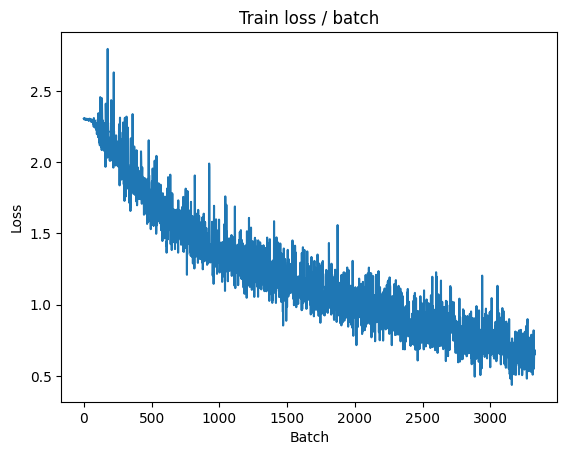


===============> Total time 9s	Avg loss 0.6603	Avg Prec@1 76.88 %	Avg Prec@5 98.81 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 0.9348 (0.9348)	Prec@1  65.6 ( 65.6)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.0340	Avg Prec@1 66.00 %	Avg Prec@5 96.61 %



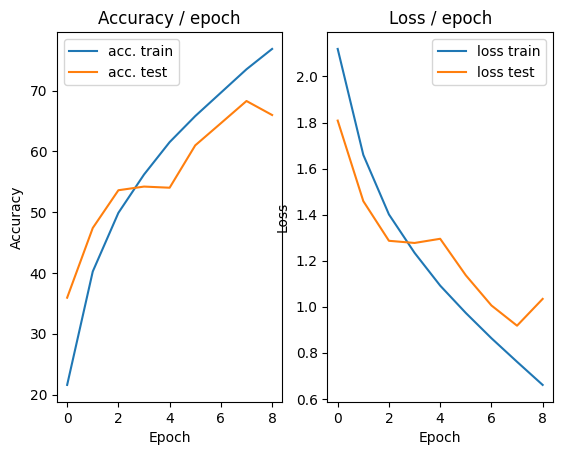

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.136s (0.136s)	Loss 0.6619 (0.6619)	Prec@1  77.3 ( 77.3)	Prec@5 100.0 (100.0)


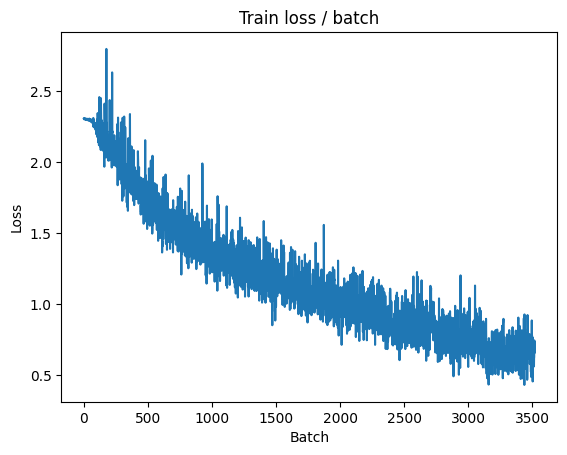

[TRAIN Batch 200/391]	Time 0.022s (0.022s)	Loss 0.5671 (0.5562)	Prec@1  79.7 ( 80.5)	Prec@5  99.2 ( 99.1)


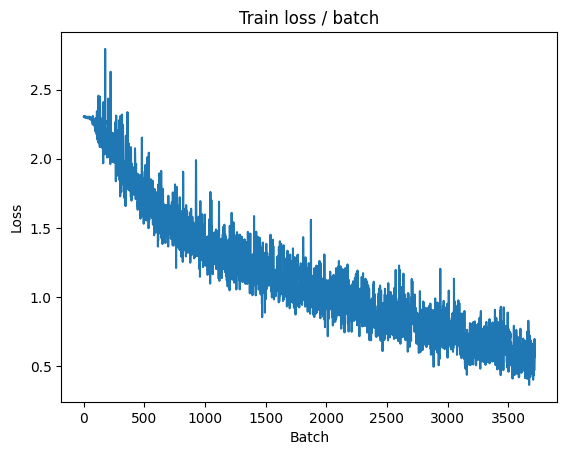


===============> Total time 9s	Avg loss 0.5648	Avg Prec@1 80.14 %	Avg Prec@5 99.19 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 0.9045 (0.9045)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0576	Avg Prec@1 66.90 %	Avg Prec@5 96.70 %



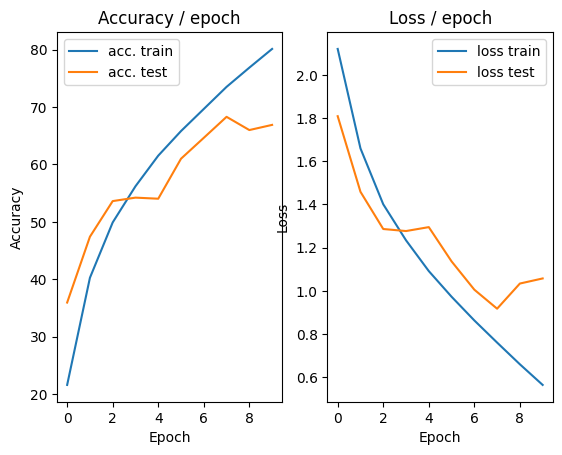

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.5734 (0.5734)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


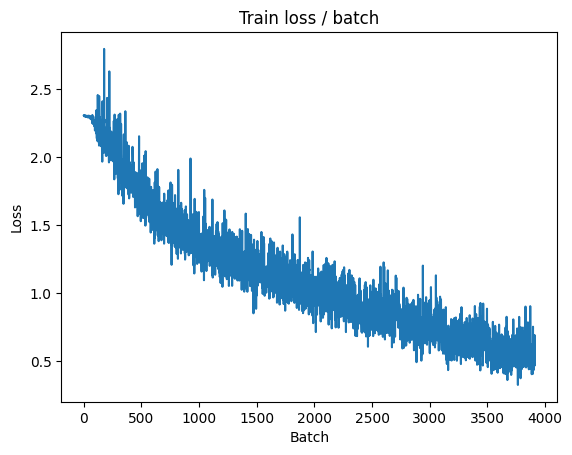

[TRAIN Batch 200/391]	Time 0.024s (0.022s)	Loss 0.5017 (0.4540)	Prec@1  86.7 ( 84.3)	Prec@5  99.2 ( 99.5)


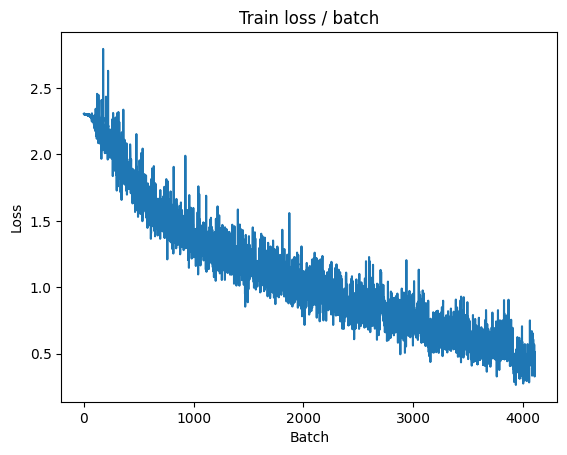


===============> Total time 10s	Avg loss 0.4680	Avg Prec@1 83.72 %	Avg Prec@5 99.47 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 1.0115 (1.0115)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9944	Avg Prec@1 67.98 %	Avg Prec@5 97.26 %



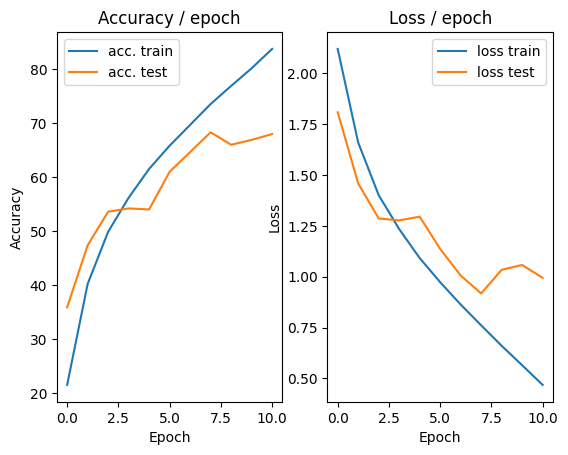

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.2480 (0.2480)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


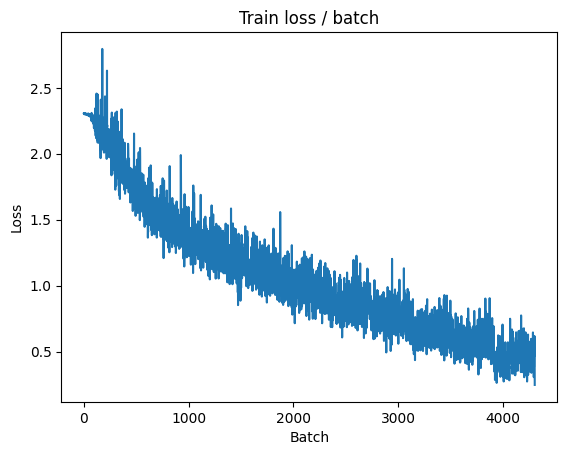

[TRAIN Batch 200/391]	Time 0.007s (0.023s)	Loss 0.4778 (0.3607)	Prec@1  86.7 ( 87.6)	Prec@5  98.4 ( 99.7)


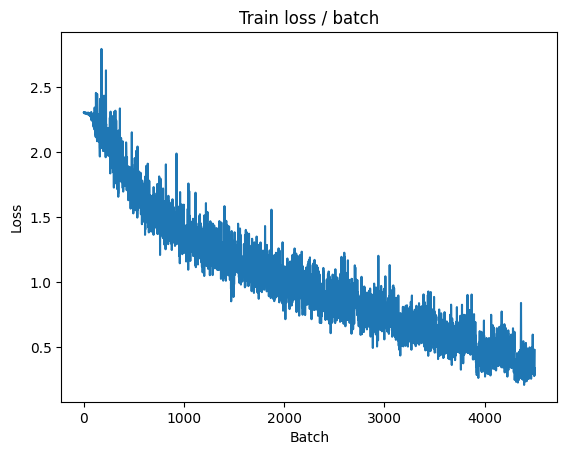


===============> Total time 9s	Avg loss 0.3772	Avg Prec@1 86.80 %	Avg Prec@5 99.70 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 1.1183 (1.1183)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0232	Avg Prec@1 68.82 %	Avg Prec@5 97.24 %



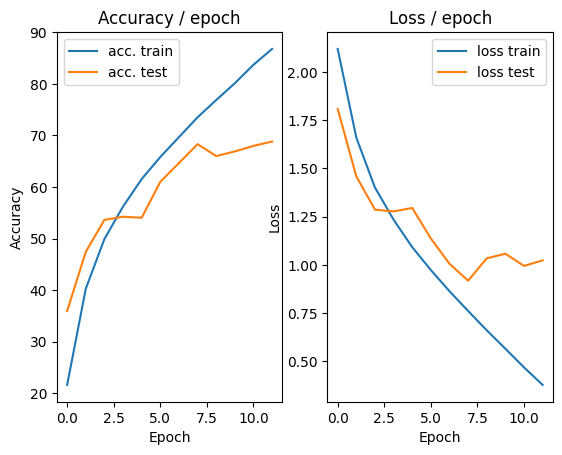

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.2692 (0.2692)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


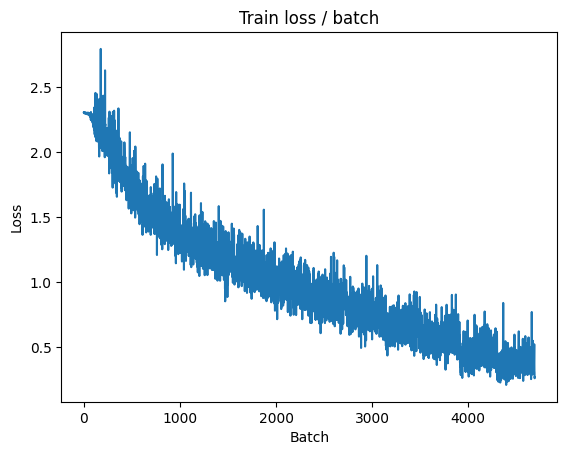

[TRAIN Batch 200/391]	Time 0.028s (0.023s)	Loss 0.2026 (0.2622)	Prec@1  93.0 ( 91.0)	Prec@5  99.2 ( 99.9)


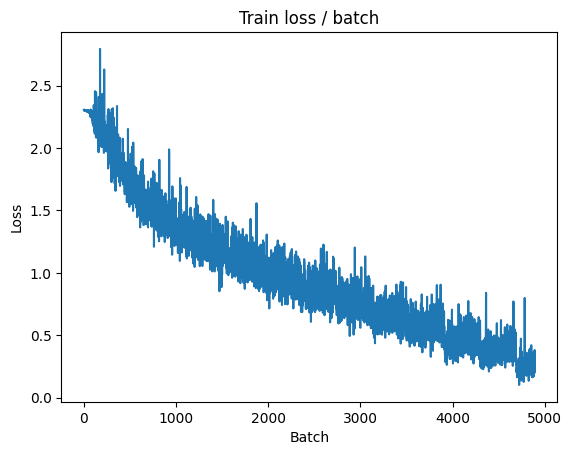


===============> Total time 8s	Avg loss 0.2858	Avg Prec@1 90.14 %	Avg Prec@5 99.85 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.1737 (1.1737)	Prec@1  65.6 ( 65.6)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.1344	Avg Prec@1 68.52 %	Avg Prec@5 97.04 %



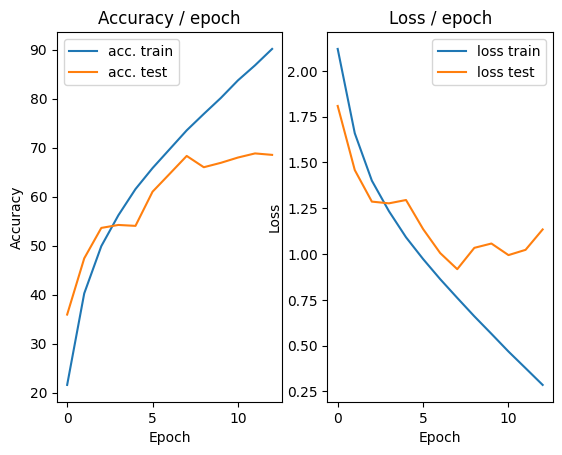

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.208s (0.208s)	Loss 0.2338 (0.2338)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


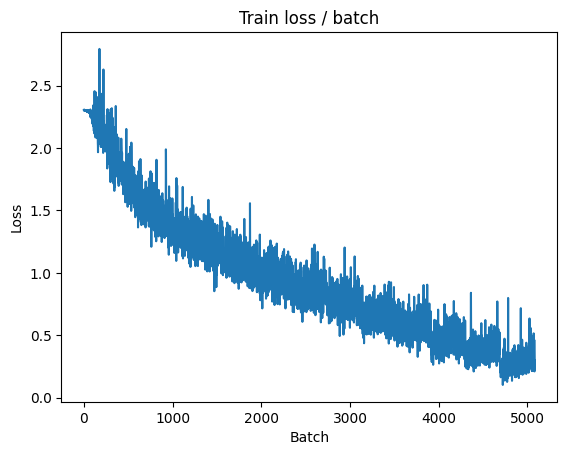

[TRAIN Batch 200/391]	Time 0.031s (0.023s)	Loss 0.1344 (0.1836)	Prec@1  96.1 ( 94.1)	Prec@5 100.0 (100.0)


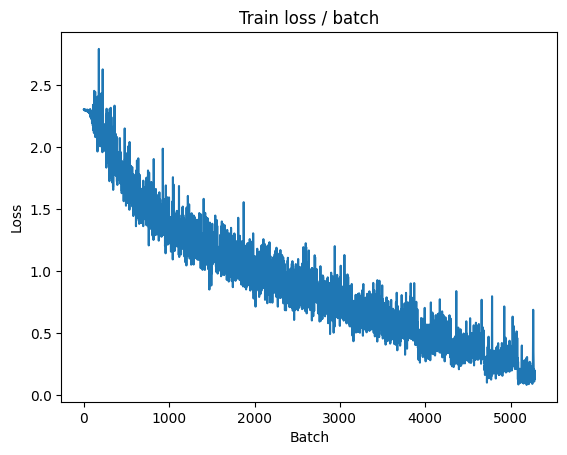


===============> Total time 8s	Avg loss 0.2049	Avg Prec@1 93.18 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 1.4474 (1.4474)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.2529	Avg Prec@1 69.26 %	Avg Prec@5 97.13 %



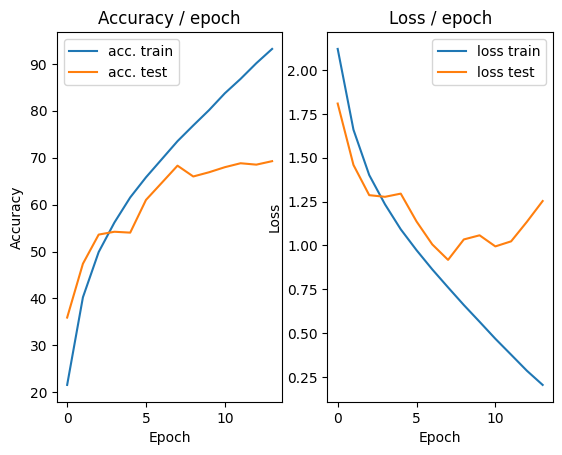

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.219s (0.219s)	Loss 0.1936 (0.1936)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


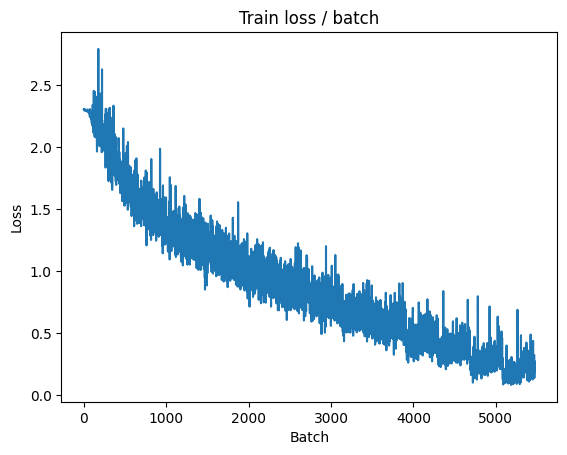

[TRAIN Batch 200/391]	Time 0.013s (0.026s)	Loss 0.1762 (0.1202)	Prec@1  93.8 ( 96.2)	Prec@5 100.0 (100.0)


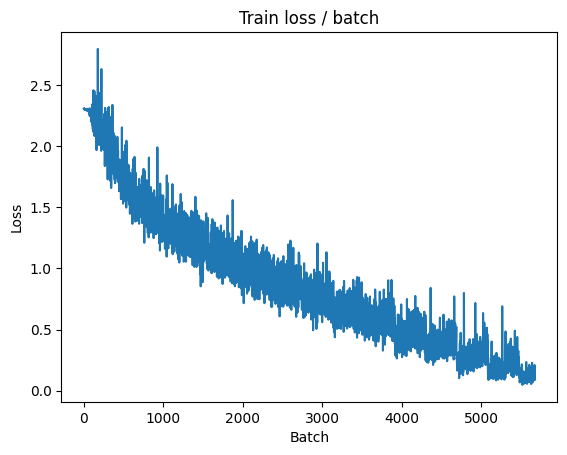


===============> Total time 9s	Avg loss 0.1736	Avg Prec@1 94.52 %	Avg Prec@5 99.90 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.1103 (1.1103)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.3121	Avg Prec@1 69.64 %	Avg Prec@5 97.05 %



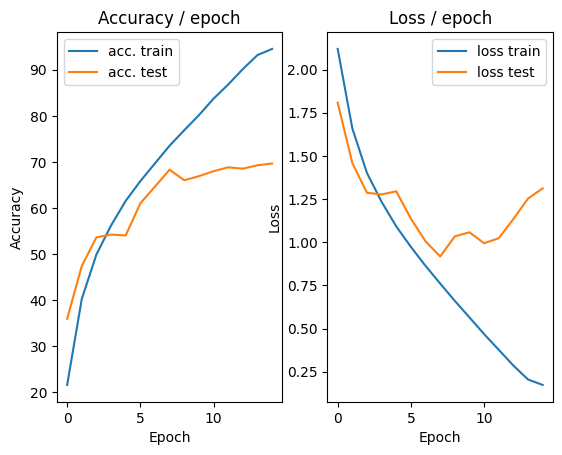

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.164s (0.164s)	Loss 0.1049 (0.1049)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


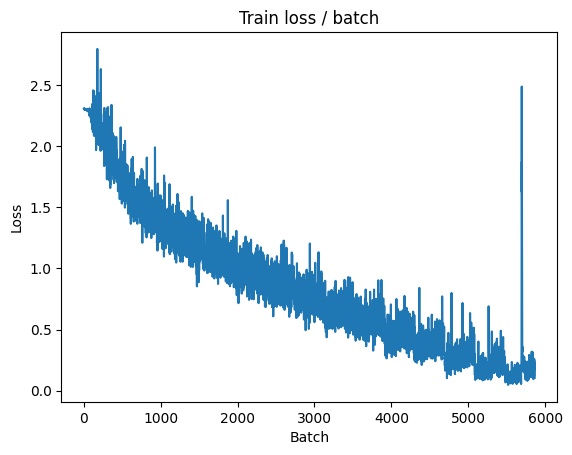

[TRAIN Batch 200/391]	Time 0.012s (0.029s)	Loss 0.1090 (0.0908)	Prec@1  96.1 ( 97.2)	Prec@5 100.0 (100.0)


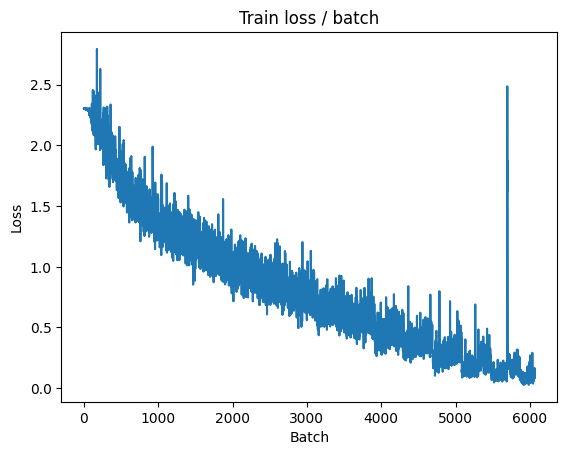


===============> Total time 9s	Avg loss 0.1104	Avg Prec@1 96.37 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.4018 (1.4018)	Prec@1  71.9 ( 71.9)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3759	Avg Prec@1 70.52 %	Avg Prec@5 96.65 %



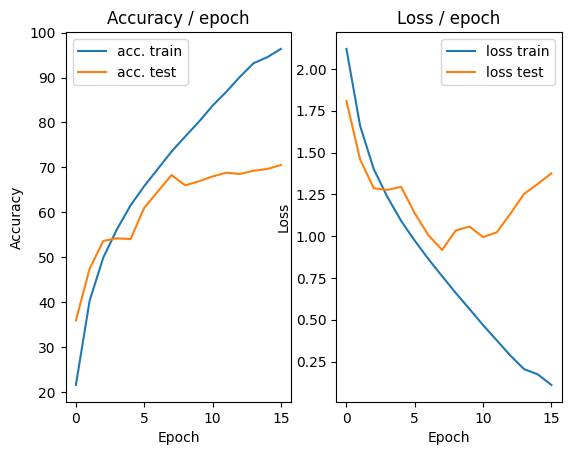

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 0.1249 (0.1249)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


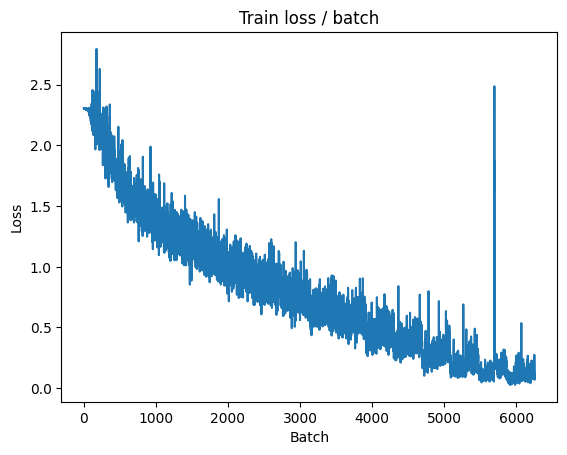

[TRAIN Batch 200/391]	Time 0.011s (0.027s)	Loss 0.0466 (0.0521)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


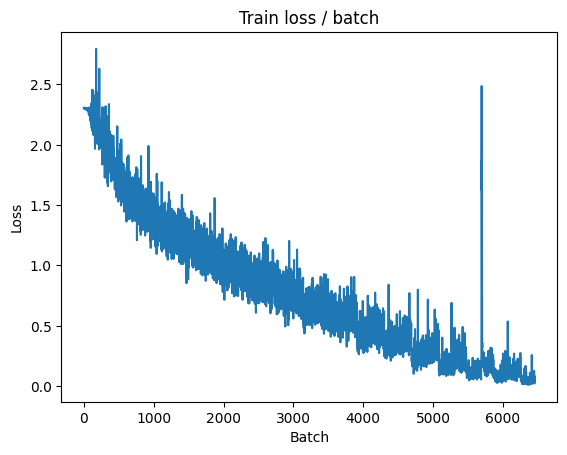


===============> Total time 9s	Avg loss 0.0746	Avg Prec@1 97.71 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 1.4268 (1.4268)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.4744	Avg Prec@1 69.30 %	Avg Prec@5 97.16 %



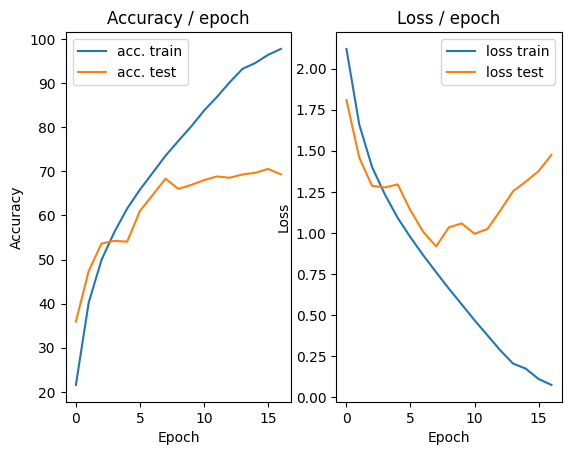

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.1323 (0.1323)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


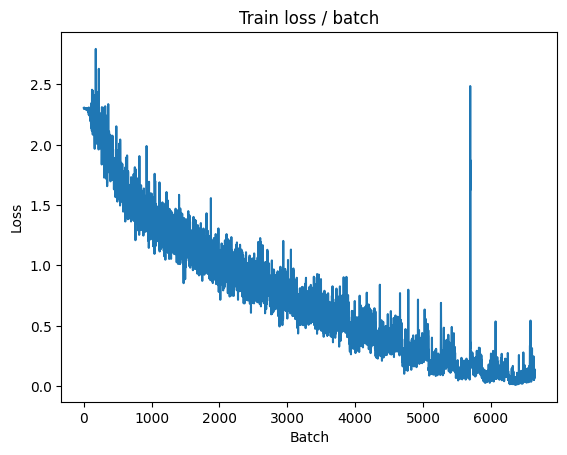

[TRAIN Batch 200/391]	Time 0.014s (0.027s)	Loss 0.0257 (0.0519)	Prec@1 100.0 ( 98.5)	Prec@5 100.0 (100.0)


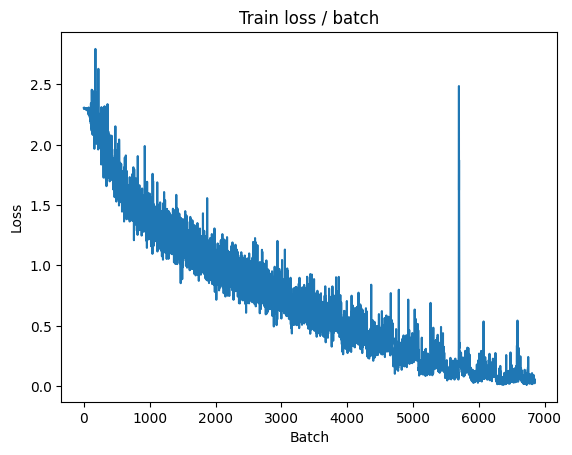


===============> Total time 9s	Avg loss 0.0625	Avg Prec@1 98.13 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.5353 (1.5353)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.5481	Avg Prec@1 70.17 %	Avg Prec@5 97.10 %



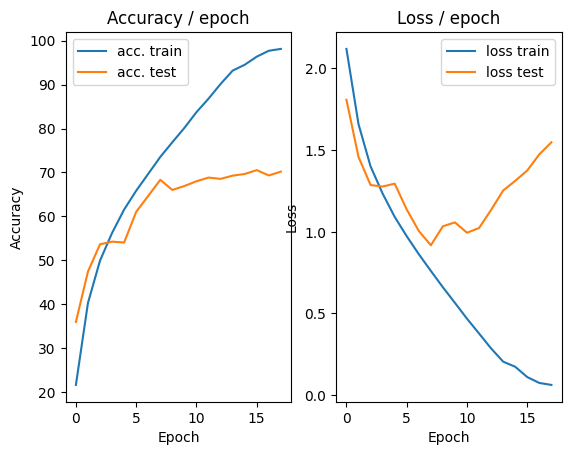

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.0586 (0.0586)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


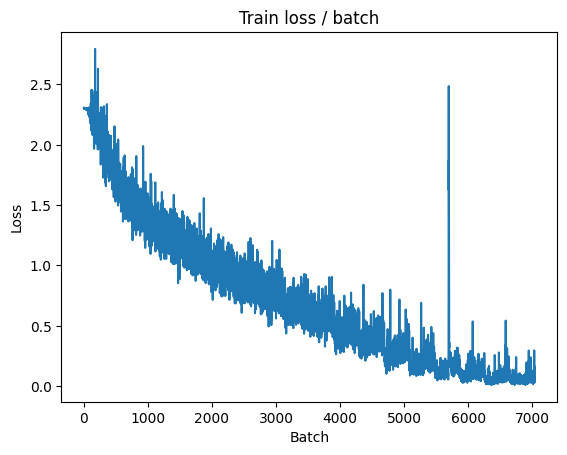

[TRAIN Batch 200/391]	Time 0.029s (0.026s)	Loss 0.0359 (0.0257)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


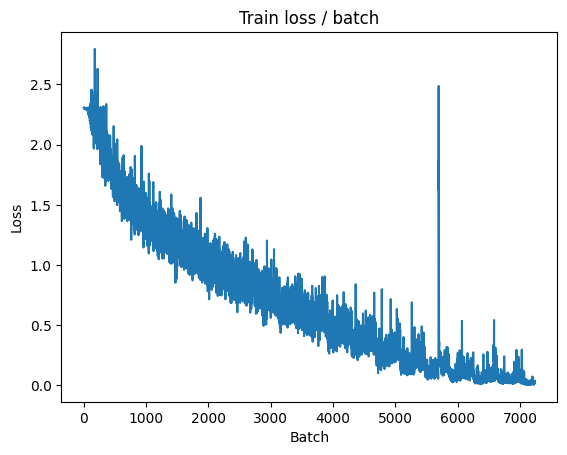


===============> Total time 9s	Avg loss 0.0358	Avg Prec@1 98.96 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 2.2660 (2.2660)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 2.1033	Avg Prec@1 67.94 %	Avg Prec@5 96.43 %



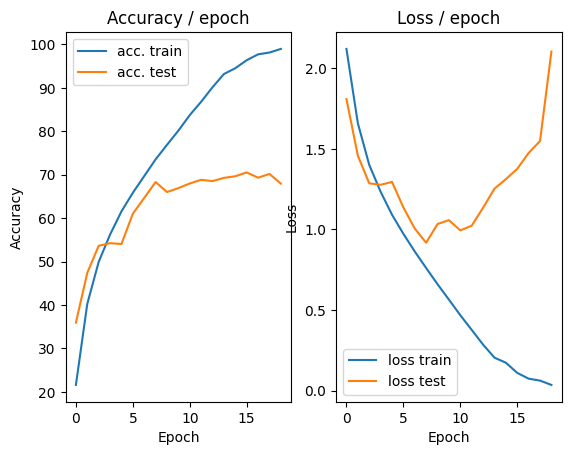

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.2799 (0.2799)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


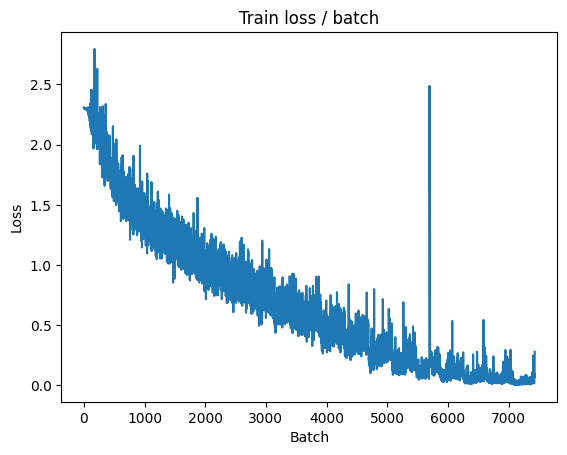

[TRAIN Batch 200/391]	Time 0.008s (0.023s)	Loss 0.0208 (0.0257)	Prec@1 100.0 ( 99.3)	Prec@5 100.0 (100.0)


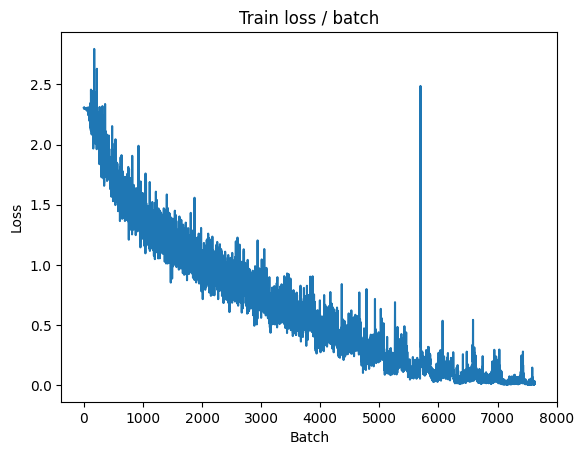


===============> Total time 9s	Avg loss 0.0210	Avg Prec@1 99.44 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.0383 (2.0383)	Prec@1  64.1 ( 64.1)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.8272	Avg Prec@1 71.10 %	Avg Prec@5 97.23 %



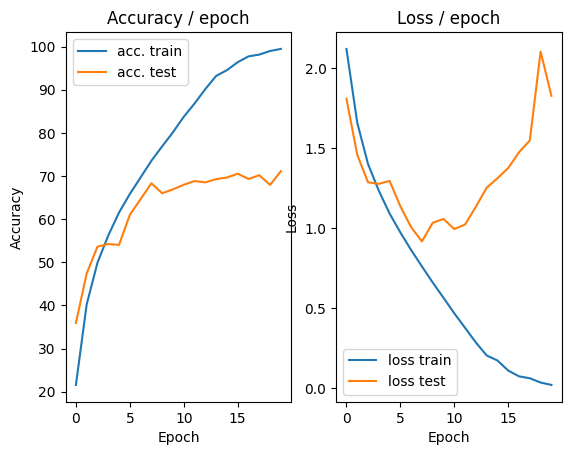

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 0.0117 (0.0117)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


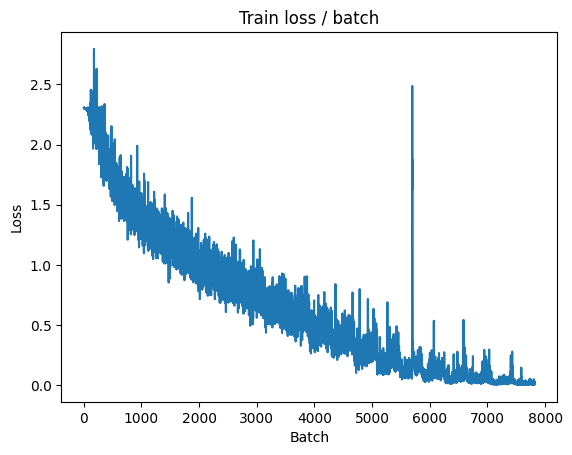

[TRAIN Batch 200/391]	Time 0.012s (0.025s)	Loss 0.0036 (0.0069)	Prec@1 100.0 ( 99.9)	Prec@5 100.0 (100.0)


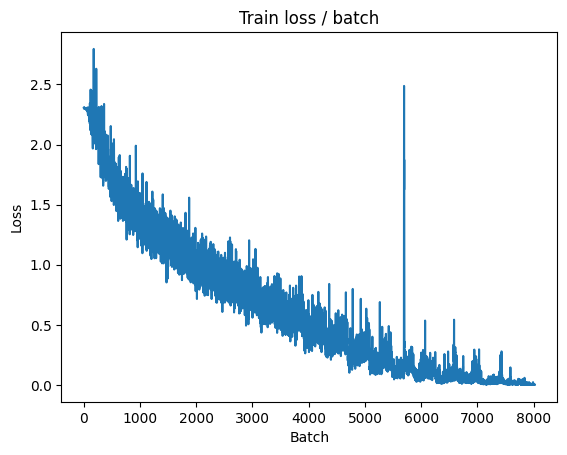


===============> Total time 10s	Avg loss 0.0060	Avg Prec@1 99.90 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 2.0335 (2.0335)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.8703	Avg Prec@1 72.08 %	Avg Prec@5 97.49 %



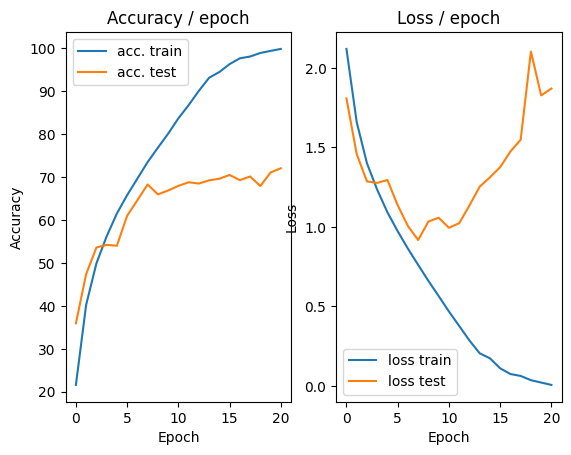

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 0.0042 (0.0042)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


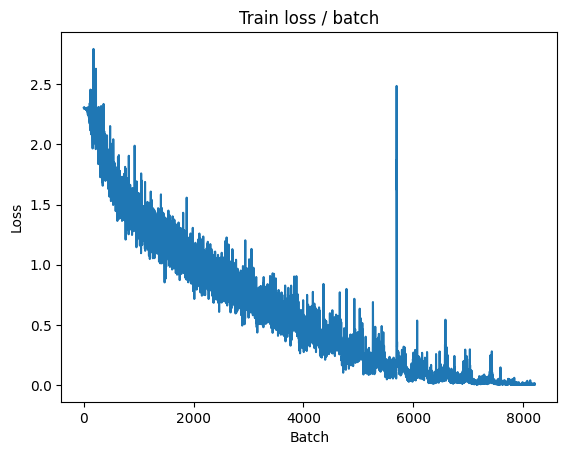

[TRAIN Batch 200/391]	Time 0.029s (0.024s)	Loss 0.0027 (0.0027)	Prec@1 100.0 ( 99.9)	Prec@5 100.0 (100.0)


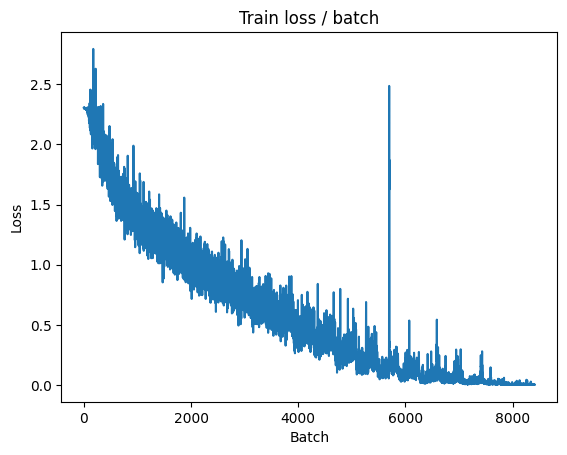


===============> Total time 10s	Avg loss 0.0027	Avg Prec@1 99.96 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 2.2390 (2.2390)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.9180	Avg Prec@1 72.14 %	Avg Prec@5 97.34 %



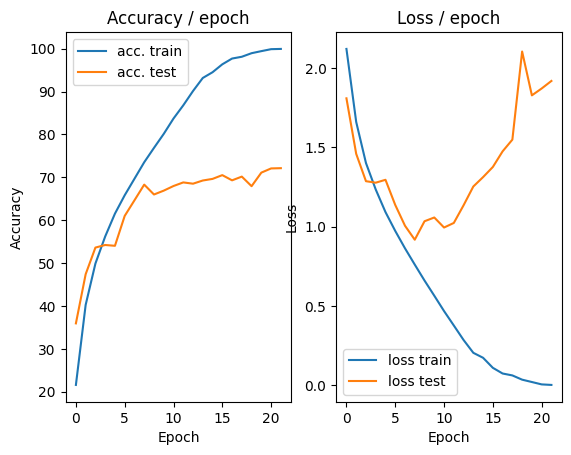

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.208s (0.208s)	Loss 0.0013 (0.0013)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


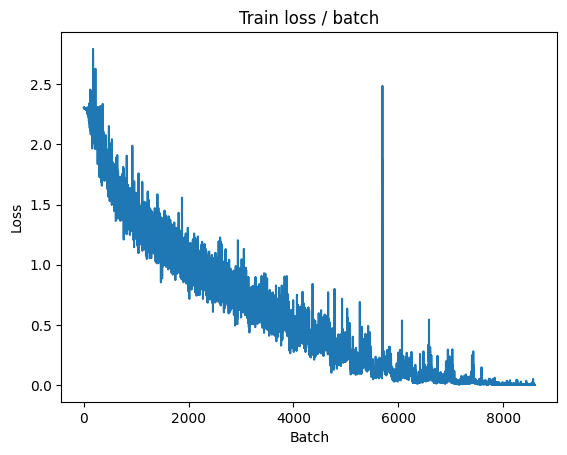

[TRAIN Batch 200/391]	Time 0.038s (0.024s)	Loss 0.0022 (0.0015)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


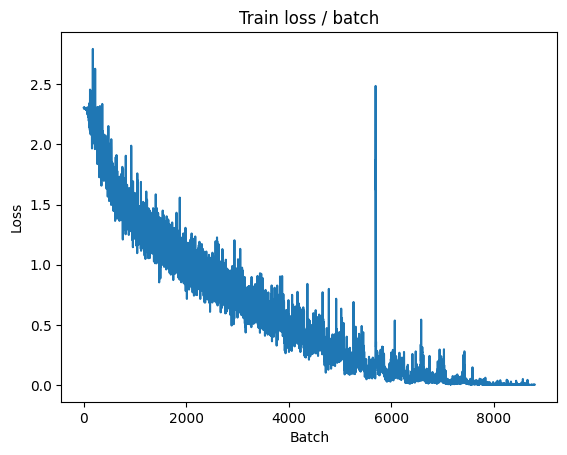


===============> Total time 10s	Avg loss 0.0013	Avg Prec@1 99.98 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.2490 (2.2490)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.0084	Avg Prec@1 72.33 %	Avg Prec@5 97.47 %



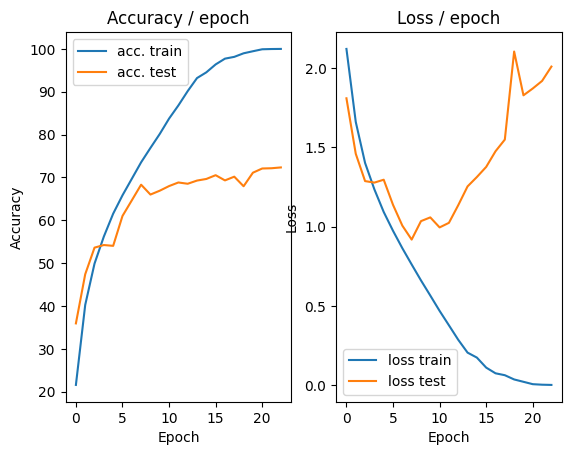

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.0016 (0.0016)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


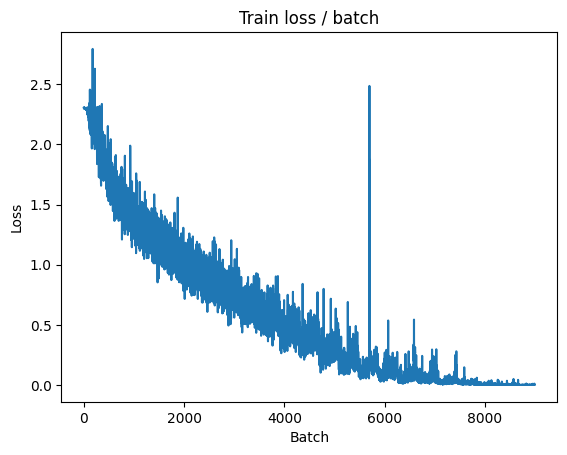

[TRAIN Batch 200/391]	Time 0.013s (0.022s)	Loss 0.0003 (0.0008)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


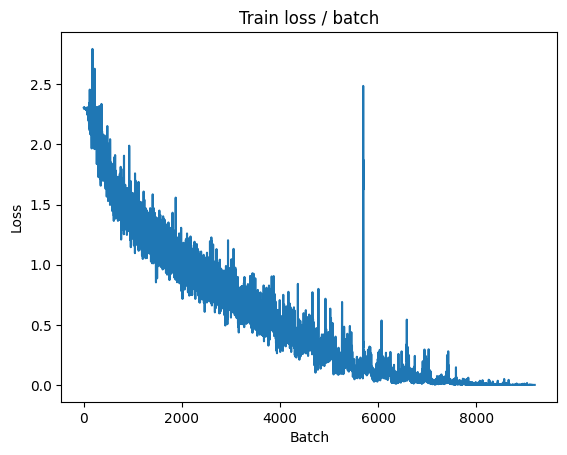


===============> Total time 9s	Avg loss 0.0007	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.202s (0.202s)	Loss 2.2839 (2.2839)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.0376	Avg Prec@1 72.59 %	Avg Prec@5 97.45 %



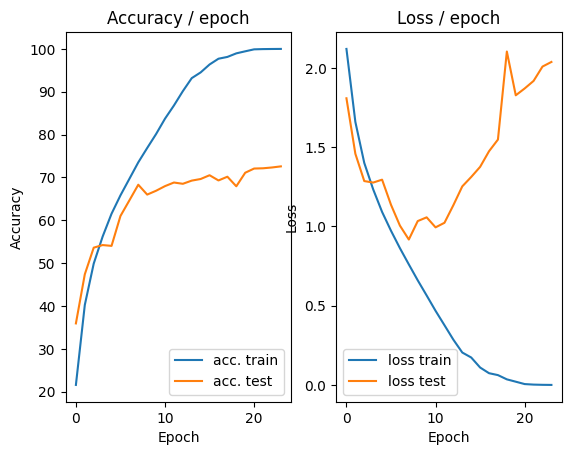

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.0004 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


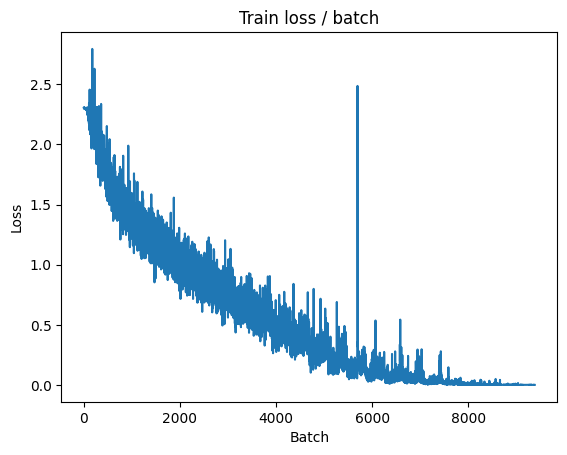

[TRAIN Batch 200/391]	Time 0.011s (0.022s)	Loss 0.0003 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


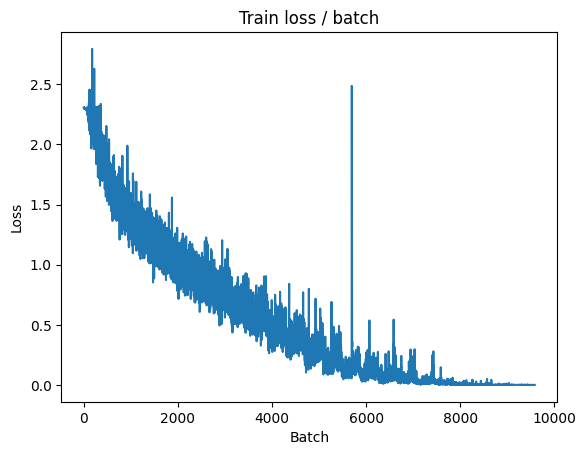


===============> Total time 8s	Avg loss 0.0004	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 2.3200 (2.3200)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 2.0784	Avg Prec@1 72.64 %	Avg Prec@5 97.52 %



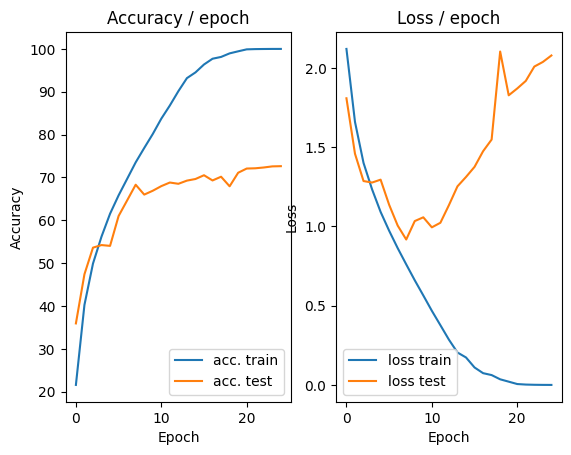

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


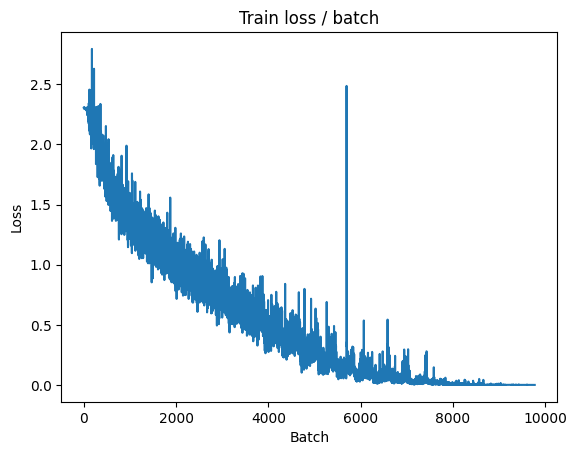

[TRAIN Batch 200/391]	Time 0.009s (0.023s)	Loss 0.0004 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


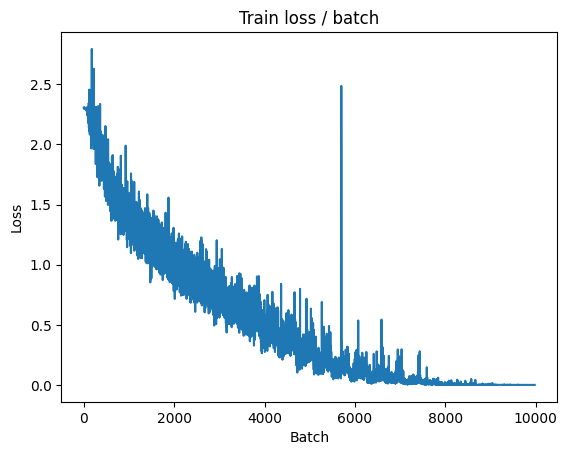


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.3610 (2.3610)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 2.1119	Avg Prec@1 72.67 %	Avg Prec@5 97.50 %



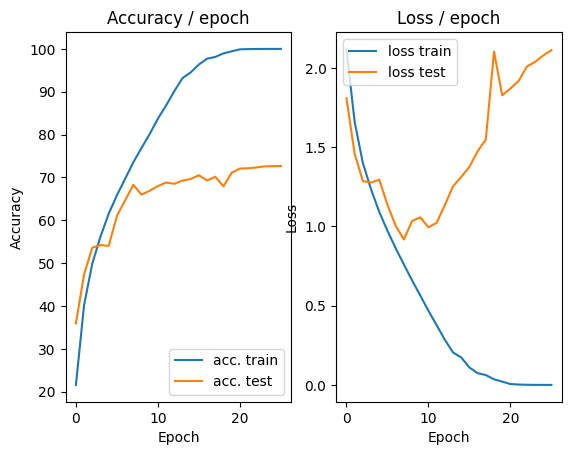

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


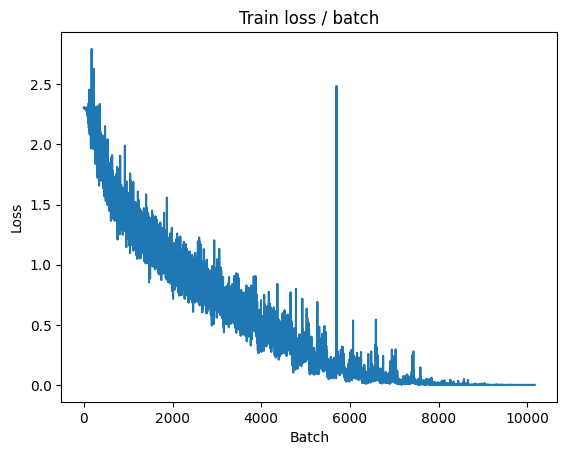

[TRAIN Batch 200/391]	Time 0.032s (0.023s)	Loss 0.0004 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


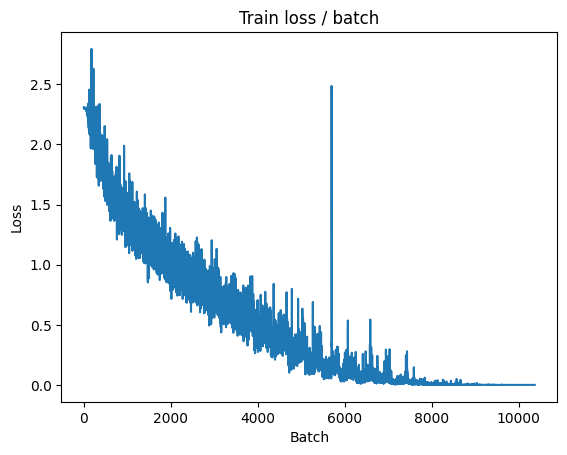


===============> Total time 8s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 2.3820 (2.3820)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1387	Avg Prec@1 72.63 %	Avg Prec@5 97.51 %



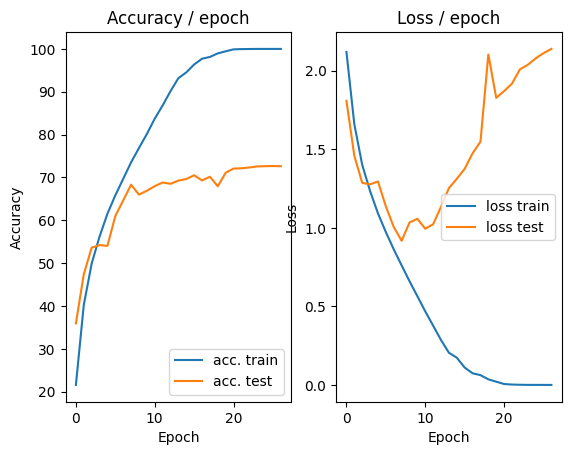

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


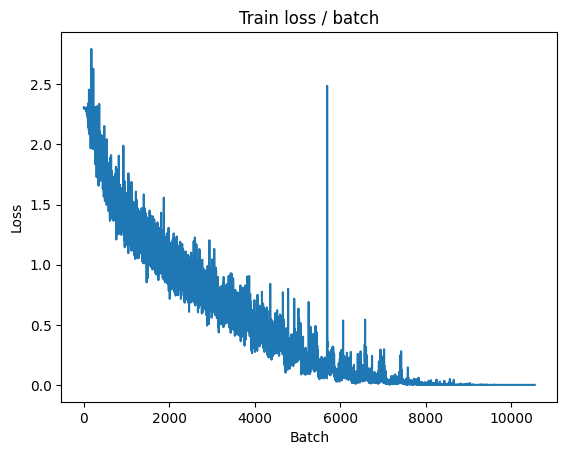

[TRAIN Batch 200/391]	Time 0.007s (0.026s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


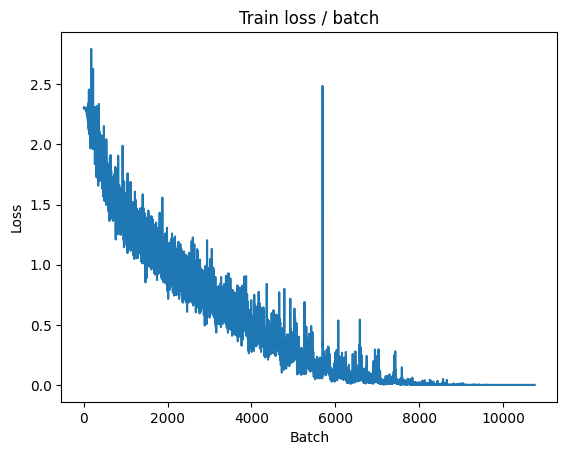


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.198s (0.198s)	Loss 2.4118 (2.4118)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1642	Avg Prec@1 72.73 %	Avg Prec@5 97.53 %



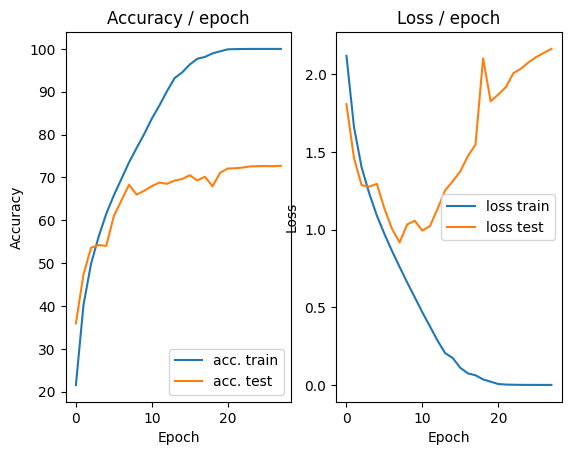

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


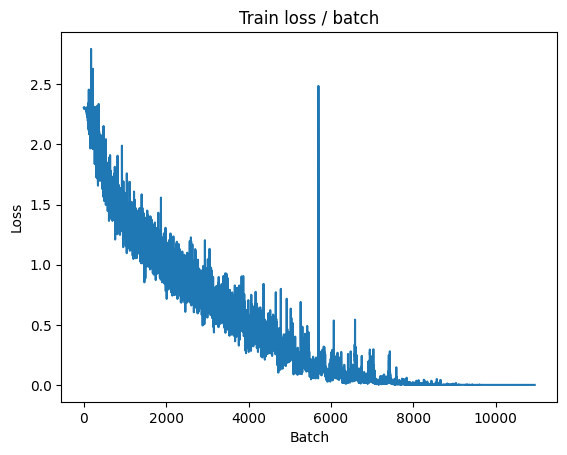

[TRAIN Batch 200/391]	Time 0.014s (0.028s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


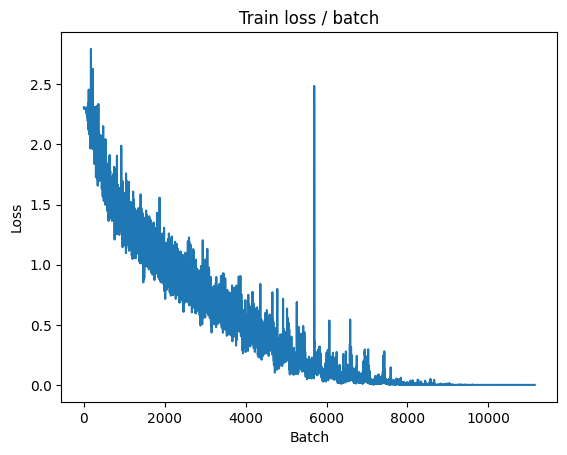


===============> Total time 9s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 2.4369 (2.4369)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1857	Avg Prec@1 72.70 %	Avg Prec@5 97.54 %



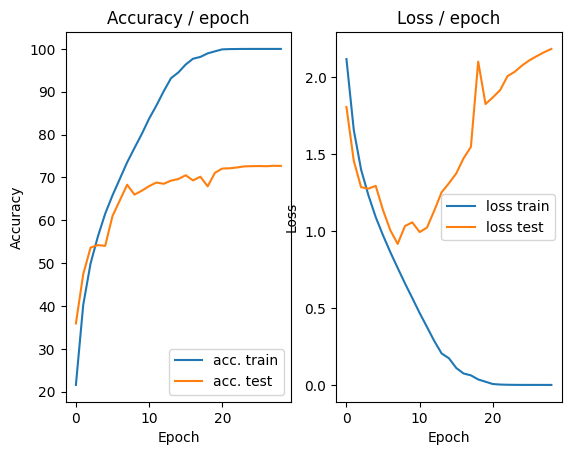

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.170s (0.170s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


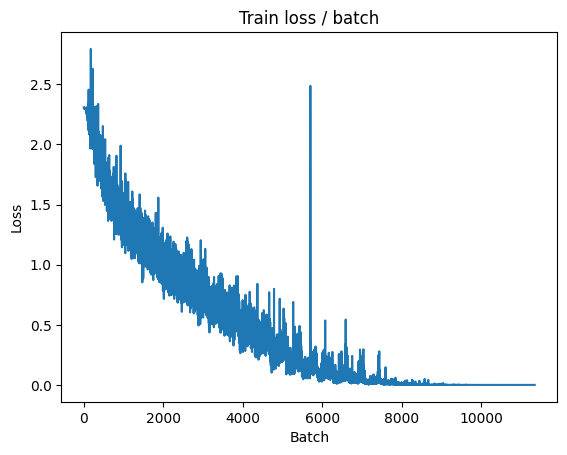

[TRAIN Batch 200/391]	Time 0.028s (0.028s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


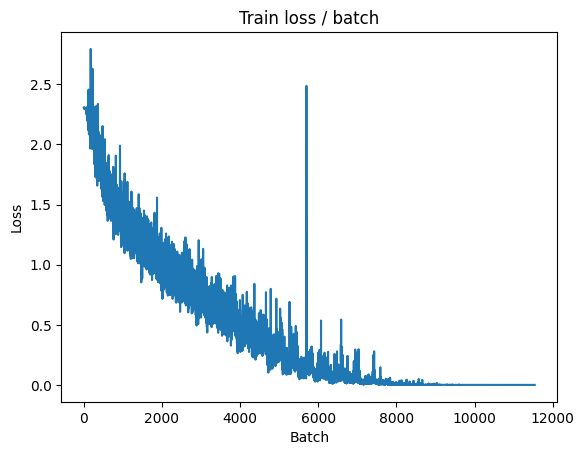


===============> Total time 9s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 2.4559 (2.4559)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.2056	Avg Prec@1 72.76 %	Avg Prec@5 97.54 %



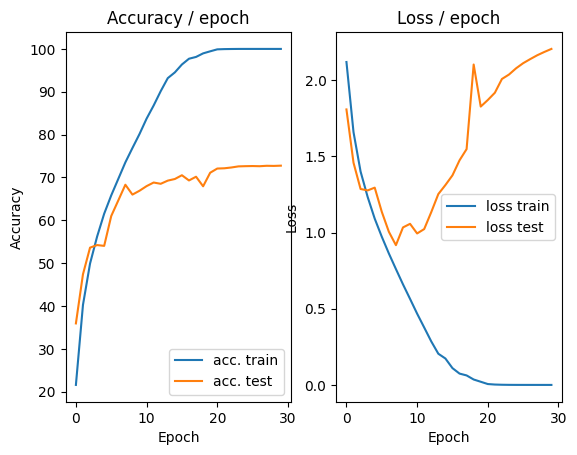

In [5]:
main(128, 0.1, epochs=30, cuda=True)

# Trial 1: My first attempt (to remain a free deep learner) !

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [11]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output



def get_dataset(batch_size, cuda=False):

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    ######################
    ### YOUR CODE HERE ###
    ######################

    # Find a way to split off a val set from the train set (you can use SubsetRandomSampler)
    train_dataset_size = len(train_dataset)
    dataset_indices = list(range(train_dataset_size))
    val_split_index = int(np.floor(0.2 * train_dataset_size))
    np.random.seed(0)
    np.random.shuffle(dataset_indices)

    train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

    train_sampler = SubsetRandomSampler(train_idx)

    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, sampler=train_sampler, pin_memory=cuda, num_workers=2)

    val_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, sampler= val_sampler , pin_memory=cuda, num_workers=2)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    # train_loader = None
    # val_loader = None
    # test_loader = None

    return train_loader, val_loader, test_loader

    ######################
    ###       END      ###
    ######################


def epoch(data, model, criterion, optimizer=None, cuda=False):

    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, val, test = get_dataset(batch_size, cuda)

    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()


    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")

        ######################
        ### YOUR CODE HERE ###
        ######################


        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Evaluation
        top1_acc_val, avg_top5_acc_val, loss_val = epoch(val, model, criterion, optimizer, cuda)

        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        plot.update(loss.avg, loss_val.avg, top1_acc.avg, top1_acc_val.avg)
    print("Final perfomance is {}".format(top1_acc_test))



Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/313]	Time 0.210s (0.210s)	Loss 2.3044 (2.3044)	Prec@1  10.2 ( 10.2)	Prec@5  41.4 ( 41.4)


<Figure size 640x480 with 0 Axes>

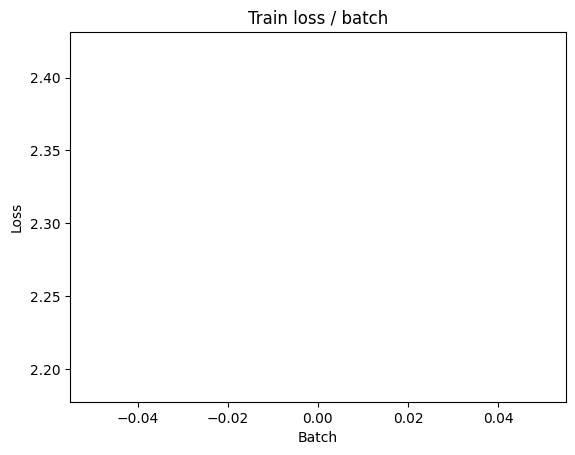

[TRAIN Batch 200/313]	Time 0.017s (0.022s)	Loss 2.1287 (2.2413)	Prec@1  28.9 ( 16.4)	Prec@5  70.3 ( 62.1)


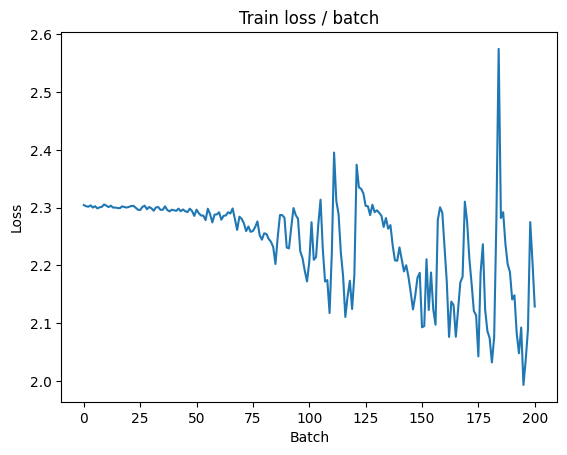


===============> Total time 6s	Avg loss 2.1770	Avg Prec@1 19.82 %	Avg Prec@5 67.14 %

[TRAIN Batch 000/079]	Time 0.148s (0.148s)	Loss 2.7480 (2.7480)	Prec@1  15.6 ( 15.6)	Prec@5  61.7 ( 61.7)


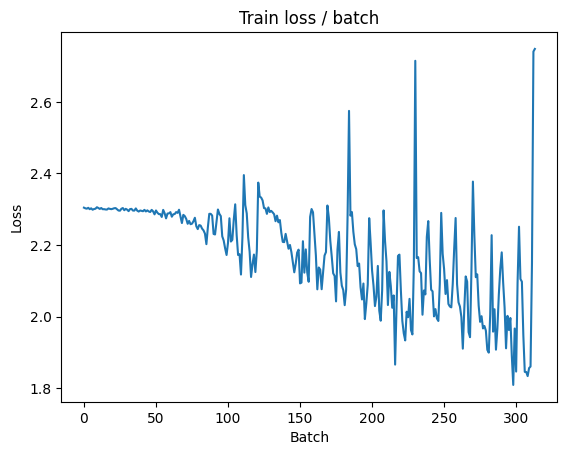


===============> Total time 2s	Avg loss 2.0035	Avg Prec@1 27.98 %	Avg Prec@5 79.45 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.9243 (1.9243)	Prec@1  33.6 ( 33.6)	Prec@5  82.0 ( 82.0)

===============> Total time 2s	Avg loss 1.9198	Avg Prec@1 29.50 %	Avg Prec@5 80.11 %



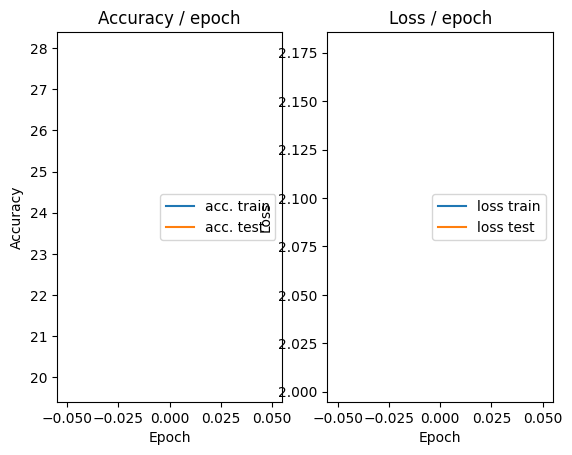

=== EPOCH 2 =====

[TRAIN Batch 000/313]	Time 0.215s (0.215s)	Loss 1.9985 (1.9985)	Prec@1  29.7 ( 29.7)	Prec@5  73.4 ( 73.4)


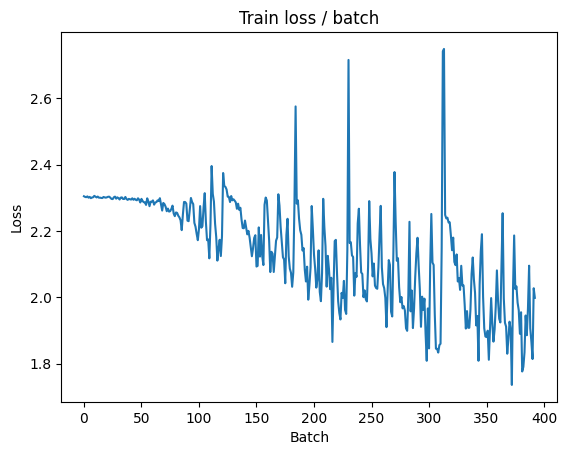

[TRAIN Batch 200/313]	Time 0.025s (0.025s)	Loss 1.7076 (1.7829)	Prec@1  38.3 ( 35.6)	Prec@5  89.8 ( 85.8)


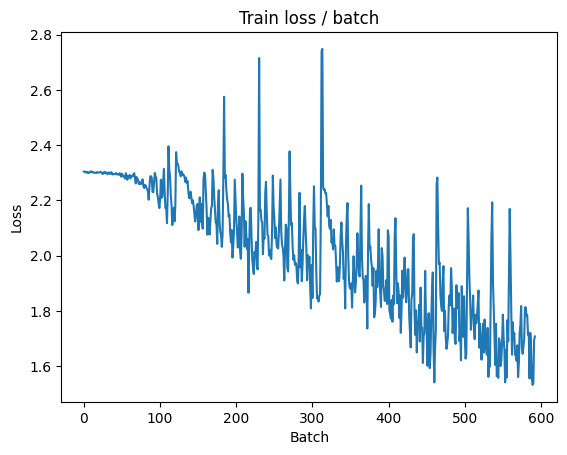


===============> Total time 7s	Avg loss 1.7317	Avg Prec@1 37.57 %	Avg Prec@5 86.96 %

[TRAIN Batch 000/079]	Time 0.155s (0.155s)	Loss 1.6755 (1.6755)	Prec@1  37.5 ( 37.5)	Prec@5  93.0 ( 93.0)


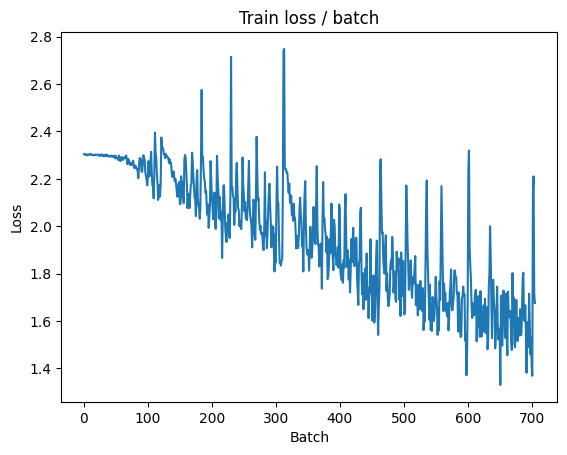


===============> Total time 2s	Avg loss 1.5579	Avg Prec@1 43.41 %	Avg Prec@5 90.73 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 1.6209 (1.6209)	Prec@1  39.8 ( 39.8)	Prec@5  88.3 ( 88.3)

===============> Total time 2s	Avg loss 1.7191	Avg Prec@1 37.15 %	Avg Prec@5 87.75 %



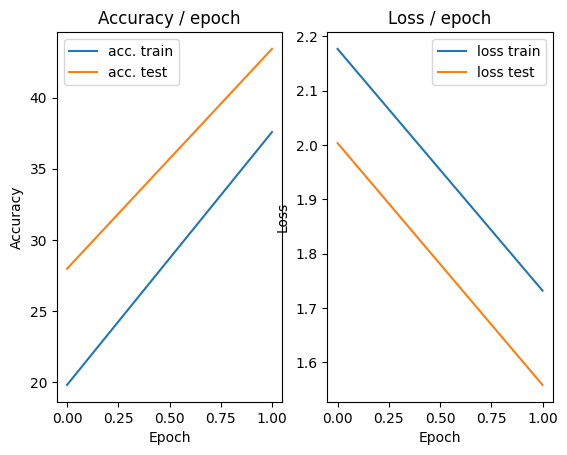

=== EPOCH 3 =====

[TRAIN Batch 000/313]	Time 0.450s (0.450s)	Loss 1.7390 (1.7390)	Prec@1  35.2 ( 35.2)	Prec@5  84.4 ( 84.4)


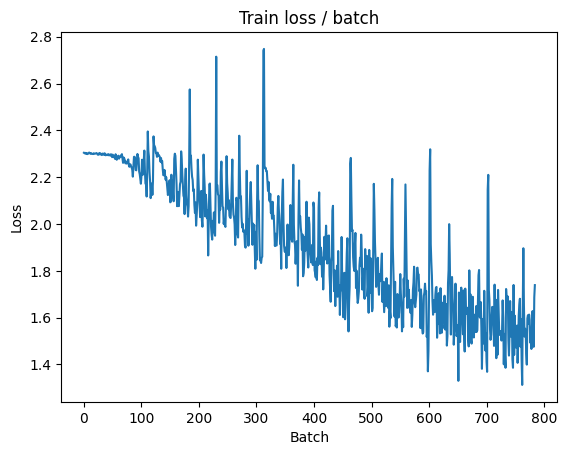

[TRAIN Batch 200/313]	Time 0.008s (0.024s)	Loss 1.5310 (1.4787)	Prec@1  44.5 ( 46.5)	Prec@5  90.6 ( 91.8)


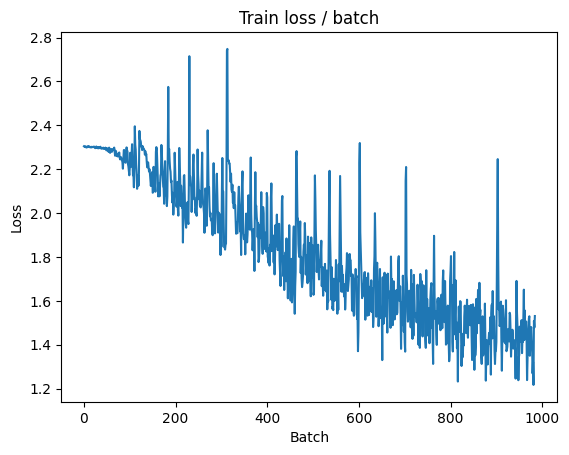


===============> Total time 7s	Avg loss 1.4468	Avg Prec@1 47.92 %	Avg Prec@5 92.11 %

[TRAIN Batch 000/079]	Time 0.148s (0.148s)	Loss 1.3762 (1.3762)	Prec@1  50.8 ( 50.8)	Prec@5  93.8 ( 93.8)


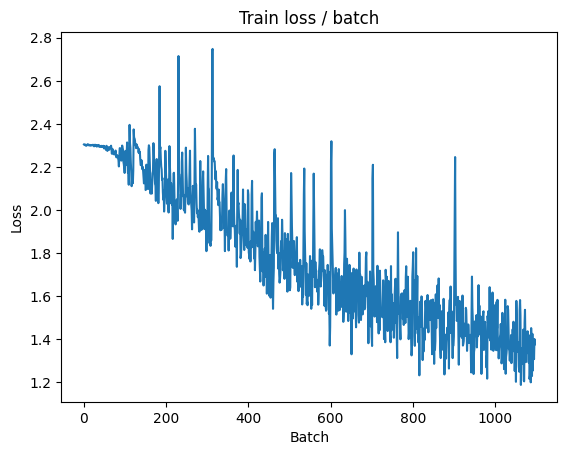


===============> Total time 2s	Avg loss 1.3527	Avg Prec@1 51.66 %	Avg Prec@5 93.24 %

[EVAL Batch 000/079]	Time 0.235s (0.235s)	Loss 1.7201 (1.7201)	Prec@1  40.6 ( 40.6)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.7425	Avg Prec@1 41.10 %	Avg Prec@5 92.32 %



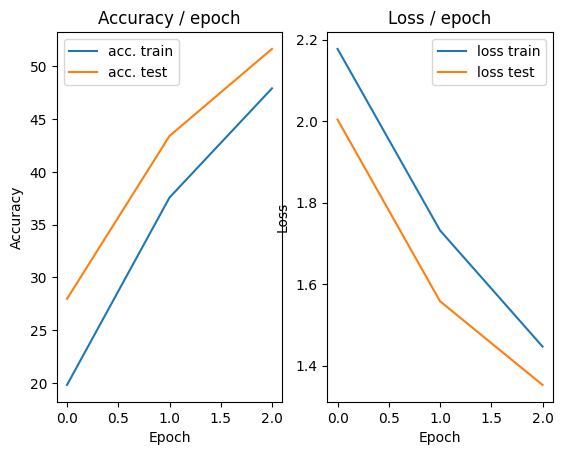

Final perfomance is <utils.AverageMeter object at 0x77ffc1d3fbb0>


In [12]:
main(128, 0.1, epochs=3, cuda=True)